In [10]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import dask
import os
from dask.distributed import Client

In [9]:
temp_dir = 'C:/dask_temp'

if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

dask.config.set({'temporary_directory': temp_dir})

In [11]:
client = Client()

client

c:\Users\aksha\OneDrive\Desktop\Urban Fleet Equilibrium Engine via Dynamic Geo-Clustering\penv\Lib\site-packages\distributed\node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64584 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:64584/status,
Dashboard: http://127.0.0.1:64584/status,Workers: 4
Total threads: 8,Total memory: 7.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64587,Workers: 0
Dashboard: http://127.0.0.1:64584/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:62584,Total threads: 2
Dashboard: http://127.0.0.1:62585/status,Memory: 1.93 GiB
Nanny: tcp://127.0.0.1:64590,


2026-01-14 17:16:28,312 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62578 (pid=19444) exceeded 95% memory budget. Restarting...
2026-01-14 17:16:28,433 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62578 (pid=19444) is slow to terminate; trying again
2026-01-14 17:16:28,525 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62578 (pid=19444) is slow to terminate; trying again
2026-01-14 17:16:28,544 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:62578' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('repartitiontofewer-081fe695ea72f5bf4568e846a8374c40', 0)} (stimulus_id='handle-worker-cleanup-1768391188.539622')
2026-01-14 17:16:28,576 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-081fe695ea72f5bf4568e846a8374c40', 0): 'waiting'}
2026-01-14 17:17:07,004 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62584 (pid=18336) exceeded 95% m

## Consideration before starting

1. Out dataset has Outliers, which we need to treat first
2. Avg time to Travel 1Km in NYC is around 10-15 mins, because we don't want our driver to travel alot, hence we will divide the map so that most of cluster or region form are approx 1miles or (10-15 mins) away from each other.
3. also we don't want a lot of region, that don't make any sense anymore, also we don't want the region to be too far that can lead to more fuel consumption of driver and take more time to reach there.

#### Removing Outliers from relevant columns that are co-ordinates, fare, distance

### Why can't we treat them?
- we can't handle/treat the outliers coordinate points by ourself, and even can't cap them because the extreme value will be capped at certain point which will show a False Demand in that region, which is wrong

- Also this outlier data is very less, dropping them will not affect distribution or model training.


#### For Dividing map into clusters, we will use Mini Batch k-means, why?
- Although Mini Batch K-means is stochastic is nature, but it is faster.
- We can use DBSCAN for clustering but it do not have partial_fit method, and hence I can't load my entire dataset, and feed to DBSCAN directly.
- One more advantage of using K-means is that we will use the centroid value of it while calculating the distance.

In [ ]:
# loading only the useful cols 

usecols = ['trip_distance', 'pickup_longitude','pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'fare_amount']

df_jan = dd.read_csv("../data/raw/yellow_tripdata_2016-01.csv", assume_missing=True, usecols=usecols)
df_feb = dd.read_csv("../data/raw/yellow_tripdata_2016-02.csv", assume_missing=True, usecols=usecols)
df_mar = dd.read_csv("../data/raw/yellow_tripdata_2016-03.csv", assume_missing=True, usecols=usecols)

In [3]:
df = dd.concat([df_jan, df_feb, df_mar], axis=0)

In [ ]:
# bouding box for NYC, to remove the outliers

min_latitude = 40.60
max_latitude = 40.85
min_longitude = -74.05
max_longitude = -73.70

In [ ]:
# computing percentiles to take a upper bound on fare amount 

percentile_values = np.arange(0.991, 1.000, 0.0005)

df['fare_amount'].quantile(percentile_values).compute()

0.9910        52.00
0.9915        52.00
0.9920        52.00
0.9925        52.00
0.9930        52.00
0.9935        52.00
0.9940        52.00
0.9945        53.50
0.9950        55.00
0.9955        57.00
0.9960        59.50
0.9965        61.50
0.9970        64.50
0.9975        67.50
0.9980        70.50
0.9985        76.00
0.9990        94.00
0.9995       125.00
1.0000    154810.43
Name: fare_amount, dtype: float64

In [21]:
min_fare = 0.50 # as per their regulation
max_fare = 125 # capping to 125 under that under this 99.95% of values present

In [ ]:
# calculating the trip distance, to calculate a upper bound 

df['trip_distance'].quantile(np.arange(0.991, 1.000, 0.001)).compute().round()

0.991          20.0
0.992          20.0
0.993          20.0
0.994          20.0
0.995          20.0
0.996          21.0
0.997          21.0
0.998          23.0
0.999          27.0
1.000    19072629.0
Name: trip_distance, dtype: float64

In [18]:
min_distance = 0.25 # a ride has to be atleast 0.25 miles of distance
max_distance = 27 # as per our data, 99.9% of trip distance is less than 27 miles

In [24]:
## removing outliers

df_final = (
    df
    .loc[
        (
            # removing coordinate that are not inside/on bounding box 
            df['pickup_latitude'].between(min_latitude, max_latitude, inclusive='both') & 
            df['pickup_longitude'].between(min_longitude, max_longitude, inclusive='both') &
            df['dropoff_latitude'].between(min_latitude, max_latitude, inclusive='both') &
            df['dropoff_longitude'].between(min_longitude, max_longitude, inclusive='both') &

            # removing outliers present in fare and trip distance
            df['fare_amount'].between(min_fare, max_fare, inclusive='both') &
            df['trip_distance'].between(min_distance, max_distance, inclusive='both')
        ),
        :
    ]
)

In [26]:
location_df = df_final[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]

location_df

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
npartitions=82,,,,
,float64,float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


[]

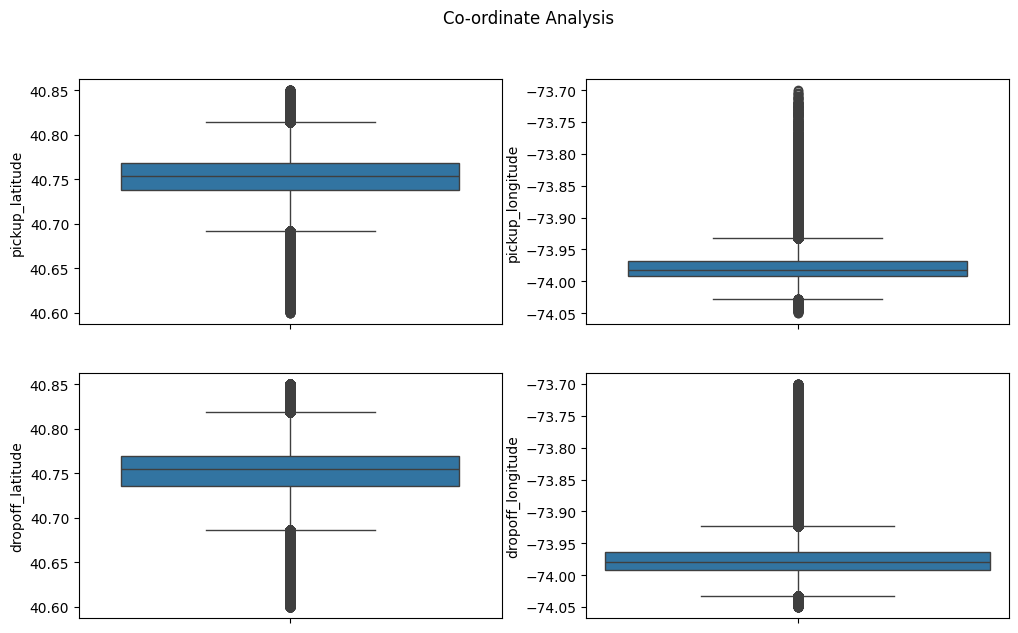

In [ ]:
# visualizing data after outlier removal

fig, ax = plt.subplots(2,2, figsize=(12,7))
ax = ax.ravel()

for i in range(4):
    sns.boxplot(y=location_df.sample(frac=0.1).iloc[:, i], ax=ax[i])

fig.suptitle('Co-ordinate Analysis after Outlier Removal')
plt.plot()

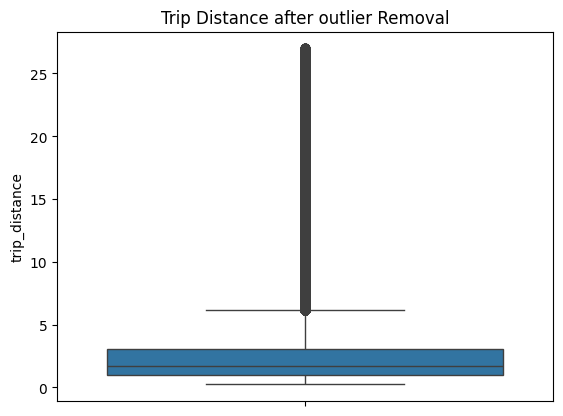

In [ ]:
sns.boxplot(df_final.sample(frac=0.1).loc[:, 'trip_distance'].compute())
plt.title('Trip Distance after outlier Removal')
plt.show()

<Axes: ylabel='fare_amount'>

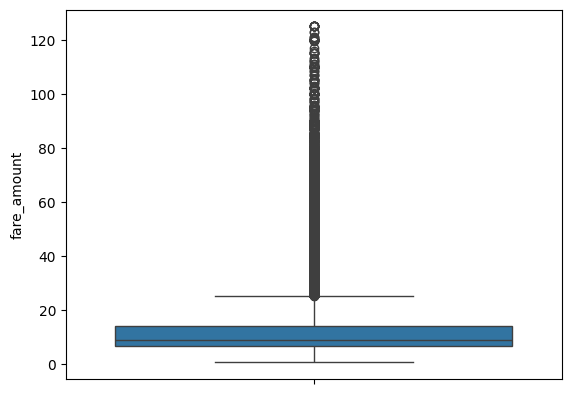

In [ ]:
sns.boxplot(df_final.sample(frac=0.1).loc[:, 'fare_amount'].compute())
plt.title('Fare Amount after Outlier Removal')
plt.show()

In [32]:
# now we need to create cluster, and it will be created by pickup points, hence seperating out pickup points and storing it in new df

pickup_df = df_final.loc[:, ["pickup_latitude", "pickup_longitude"]]

In [ ]:
# exporting data for creating the partition(clusters) in NYC map

pickup_df.to_csv(
    '../data/interim/pickup_coordinate.csv',
    single_file=True,
    index=False
)

['c:\\Users\\aksha\\OneDrive\\Desktop\\Urban Fleet Equilibrium Engine via Dynamic Geo-Clustering\\data\\interim\\pickup_coordinate.csv']